In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_runner
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dataclasses
import pandas as pd
import statsmodels.api as sm
import ISLP
import ISLP.models
import subprocess
import io
import shutil
import flg_diagnostics

MainProcess


In [2]:
res_dir = fls.result_dir + '/many_abbr_res/'
temp_dir = fls.temp_dir + '/temptemp/'
fls.remove_and_make_dir(res_dir)
fls.remove_and_make_dir(temp_dir)
fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated/', temp_dir)
shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)
fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated-2/', temp_dir)
shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)
fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated-3/', temp_dir)
shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)

'd:/flagellar/results//many_abbr_res/'

In [3]:
# Read results from vast.ai
files = glob.glob(res_dir + '*0e*.pickle')
data_list = []
missing_values = dict()
modifier_values_list = []
for f in files:    
    print(f)
    data_list.append(fls.dill_load(f)    )
    #if not (data_list[-1].modifier_values['seed']>=5): print('skip'); continue
    modifier_values_list.append(data_list[-1].modifier_values)
    #print(modifier_values_list[-1])
    for key,value in data_list[-1].modifier_dict.items():
        missing_values[key] = value.missing_value
    if not data_list[-1].exception == 0:
        print(data_list[-1].exception)
        del data_list[-1]
    #print(modifier_values_list[-1])

d:/flagellar/results//many_abbr_res\Baseline_0L_0e407606_915 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1000L_0e407606_925 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_2000L_0e407606_909 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_2001L_0e407606_925 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_2002L_0e407606_911 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_2003L_0e407606_931 _a.pickle


In [4]:
import flg_model
dicts = []
dicts_kaggle_comp = []
for data, modifier_values in zip(data_list, modifier_values_list):

    d = copy.deepcopy(missing_values)
    #print(modifier_values)
    for key,value in modifier_values.items():
        d[key] = value
        #print(d)
    d['lr0_times_nepochs'] = d['lr0']*d['n_epochs']
    #print(d)
    #raise 'stop'
    # if predict_all:
    #     data.trained_model.data_after_step2 = data.inferred_test_data     
    #     data.trained_model.step3Output.threshold=-1
    #     data.inferred_test_data = data.trained_model.infer(data.test_data)
        
    d['label'] = data.label
    d['git_commit_id'] = data.git_commit_id
    d['use_missing_value'] = data.use_missing_value

    # Reinfer
    

    # false_conf = []
    # true_conf = []
    # for dd,r in zip(data.inferred_test_data, data.test_data):
    #     if len(r.labels)>0:
    #         true_conf.append(dd.labels['confidence'][0])
    #     else:
    #         false_conf.append(dd.labels['confidence'][0])
    # plt.figure()
    # plt.hist(true_conf,alpha=0.5)
    # plt.hist(false_conf,alpha=0.5)

    if data.inferred_test_data==0:
        d['cv_score'] = np.nan
    else:
        # model = data.untrained_model
        # model.state = 1
        # model.data_after_step2 = data.inferred_test_data
        # import io
        # import contextlib
        # model.step2Motors = flg_model.FindClustersMultiZ()
        # model.step2Motors.z_range = 4
        # model.run_in_parallel = False
        # with contextlib.redirect_stdout(io.StringIO()) as f:
        #     data.inferred_test_data = model.infer(data.test_data) 
        dat, test_data = flg_diagnostics.expand_and_reinfer(data.inferred_test_data, data.test_data, data.untrained_model.step3Output.select_motors, 0.7)
        metric = fls.score_competition_metric(dat, test_data)
        print(d['seed'], metric)
        d['cv_score'] = metric[2]
    #print(d['cv_score'])

    d_kaggle_comp = dict()
    d_kaggle_comp['label'] = data.label
    d_kaggle_comp['git_commit_id'] = d['git_commit_id']
    d_kaggle_comp['use_missing_value'] = d['use_missing_value']
    d_kaggle_comp['seed'] = d['seed']   
    d_kaggle_comp['cv_score'] = d['cv_score']
    d_kaggle_comp['k_score'] = np.nan

    #print(len(data.test_data))

    dicts_kaggle_comp.append(d_kaggle_comp)

    # if not d['cos_lr'] or not d['trust_neg']==1 or d['use_pretrained_weights']:
    #     print('skip')
    #     continue
    # First set
    #if not (d['seed']<26 or d['use_missing_value']): print('skip'); continue

    # New
    #if not (d['seed']>=26 or d['use_missing_value']): print('skip'); continue
    #if d['label']=='Test ensemble': continue

    
    
    
    for partial in fls.DataSelector().datasets:
        try:
            data_selector = fls.DataSelector()
            data_selector.datasets = [partial]
            d['cv_score_' + partial] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))[2]
        except:
            d['cv_score_' + partial] = np.nan

    try:
        data_selector = fls.DataSelector()
        data_selector.datasets = ['ycw', 'mba', 'aba']
        d['cv_score_other'] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))[2]
    except:
        d['cv_score_other'] = np.nan
    
    d['k_score']= np.nan

    dicts.append(d)    
p = pd.DataFrame(dicts)
p.sort_values(['seed', 'git_commit_id'], inplace=True);

p_kaggle_comp = pd.DataFrame(dicts_kaggle_comp)
p_kaggle_comp.sort_values(['seed', 'git_commit_id'], inplace=True);

# First set
# p = p[np.logical_or(p['seed']<26, p['use_missing_value'])]

# New
#p = p[np.logical_or(p['seed']>=26, p['use_missing_value'])]

p = p.reset_index()
p_kaggle_comp = p_kaggle_comp.reset_index()

0 (0.5335276967930029, 0.915, 0.800524934383202)
1000 (0.5362318840579711, 0.925, 0.8078602620087336)
2000 (0.5348837209302325, 0.92, 0.8041958041958042)
2001 (0.5402298850574713, 0.94, 0.818815331010453)
2002 (0.5321637426900585, 0.91, 0.7968476357267951)
2003 (0.5375722543352601, 0.93, 0.8115183246073299)


In [5]:
# Load Kaggle results
#if predict_all:
#    kaggle_results_file = fls.code_dir + '../kaggle_results_predict_all.csv'
#else:
kaggle_results_file = fls.code_dir + '../kaggle_results.csv'
p_kaggle_results = pd.read_csv(kaggle_results_file).reset_index()

In [6]:
# Add competition results
csv = subprocess.run('kaggle competitions submissions -q -csv -c byu-locating-bacterial-flagellar-motors-2025', encoding = 'utf-8', shell=True, stdout=subprocess.PIPE)
lines = csv.stdout.split('\n')[1:]
data_str = "\n".join(lines)
p_submissions = pd.read_fwf(io.StringIO(data_str), skiprows=[1])
for i_i in range(len(p_kaggle_results)):
    mv_str = 'Ma' if p_kaggle_results.loc[i_i, 'use_missing_value'] else ''
    name_str = p_kaggle_results.loc[i_i, 'label'] + '_' + str(p_kaggle_results.loc[i_i, 'seed']) + mv_str + '_' + p_kaggle_results.loc[i_i, 'git_commit_id'][:8]
    #if predict_all:
    #    name_str = name_str + ' predict all'
    for i_k in range(len(p_submissions)):
        if name_str == p_submissions.loc[i_k, 'description']:
            score = p_submissions.loc[i_k, 'publicScore']
            if not np.isnan(score):
                if np.isnan(p_kaggle_results.loc[i_i, 'k_score']):
                    p_kaggle_results.loc[i_i, 'k_score'] = score
                    print(f'Added score of {score:1.3} for {name_str}')
                else:
                    if not score == p_kaggle_results.loc[i_i, 'k_score']:
                        raise Exception(f'Mismatch for {name_str}: {score:1.3} vs {p_kaggle_results.loc[i_i, "k_score"]:1.3}')
            else:
                print('NaN score found for ', name_str)            
            break

In [7]:
#print(p_kaggle_results)
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p_kaggle_comp)):
        if p_kaggle_results['seed'][i_k] == p_kaggle_comp['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p_kaggle_comp['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p_kaggle_comp['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p_kaggle_comp['label'][i_i]:
            p_kaggle_comp.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p)):
        if p_kaggle_results['seed'][i_k] == p['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p['label'][i_i]:
            p.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]

In [8]:
# Write results to Kaggle results file
p_kaggle_cache = copy.deepcopy(p_kaggle_comp[['label', 'git_commit_id', 'use_missing_value', 'seed', 'cv_score', 'k_score']])
p_kaggle_cache.to_csv(kaggle_results_file)

In [9]:
p.to_csv(fls.code_dir + '../results.csv')
p

,index,n_ensemble,concentration,extra_data,trust_neg,trust_extra,negative_label_threshold,target_voxel_spacing,blur_xy,scale_moving_std,...,z_range,seed,lr0_times_nepochs,label,git_commit_id,use_missing_value,cv_score,cv_score_tom,cv_score_other,k_score
0,0,1,2,True,1,2,0.602049,20.082638,39.398107,True,...,6,0,0.075051,Baseline,0e407606d4b283d3abf1fa7a85b1ca3b27089470,False,0.800525,0.911111,0.917313,NaN
1,1,1,1,True,1,4,0.623547,21.016240,30.862771,False,...,3,1000,0.041334,Baseline,0e407606d4b283d3abf1fa7a85b1ca3b27089470,False,0.807860,0.896861,0.933076,NaN
2,2,1,1,True,1,1,0.601352,22.532786,34.415054,False,...,3,2000,0.026059,Baseline,0e407606d4b283d3abf1fa7a85b1ca3b27089470,False,0.804196,0.882353,0.917313,NaN
3,3,1,1,True,1,1,0.623755,24.810742,27.959368,False,...,4,2001,0.032532,Baseline,0e407606d4b283d3abf1fa7a85b1ca3b27089470,False,0.818815,0.919283,0.927835,NaN
4,4,1,2,True,2,0,0.632906,20.756282,35.775660,False,...,3,2002,0.032059,Baseline,0e407606d4b283d3abf1fa7a85b1ca3b27089470,False,0.796848,0.911111,0.912031,NaN
5,5,1,2,True,0,4,0.632567,24.992072,44.463818,False,...,6,2003,0.033133,Baseline,0e407606d4b283d3abf1fa7a85b1ca3b27089470,False,0.811518,0.927602,0.933076,NaN


In [10]:
p_part = p[p['n_ensemble']==1]
print(p_part['cv_score'])
print(np.mean(p_part['cv_score']), np.std(p_part['cv_score']))

0    0.800525
1    0.807860
2    0.804196
3    0.818815
4    0.796848
5    0.811518
Name: cv_score, dtype: float64
0.8066270486553863 0.007220148749860894


['n_ensemble',
 'concentration',
 'extra_data',
 'trust_neg',
 'trust_extra',
 'negative_label_threshold',
 'target_voxel_spacing',
 'blur_xy',
 'scale_moving_std',
 'scale_moving_average_size',
 'scale_moving_std_size_fac',
 'blur_xy_moving_std',
 'clip_value',
 'scale_percentile_value',
 'img_size',
 'box_size',
 'n_epochs',
 'use_best_epoch',
 'lr0',
 'cos_lr',
 'dropout',
 'weight_decay',
 'box',
 'model_name',
 'use_pretrained_weights',
 'mosaic_mode',
 'translate',
 'scale',
 'mixup',
 'erasing',
 'hsv_h',
 'hsv_s',
 'hsv_v',
 'fliplr',
 'flipud',
 'absolute_threshold',
 'distance_threshold',
 'z_range',
 'seed',
 'lr0_times_nepochs']

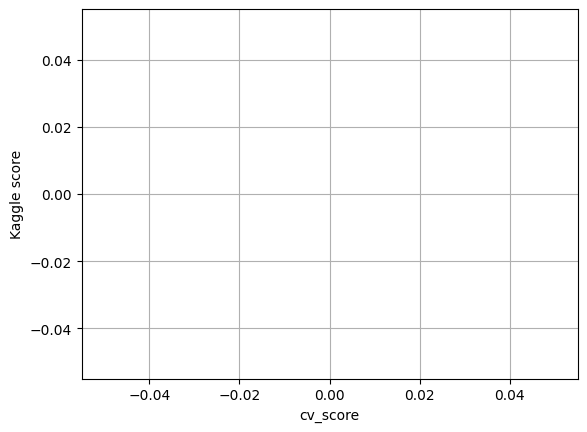

In [11]:
to_plot = copy.deepcopy(p).columns.to_list()[1:-7]
main = np.logical_and(np.logical_not(p['use_missing_value']), np.logical_not(p['cv_score']==-1.))
#print(main)
#print(p['model_name']=='yolov8m')
#main = p['tom']
for x_val in ['cv_score']:
     plt.figure()
     plt.scatter(p[x_val][main], p['k_score'][main])
     plt.grid(True)
     plt.xlabel(x_val)
     plt.ylabel('Kaggle score')
to_plot

C:\Users\jeroe\AppData\Local\Temp\ipykernel_22084\2604761752.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['trust_extra0'] = (p['trust_extra']==0)[todo]


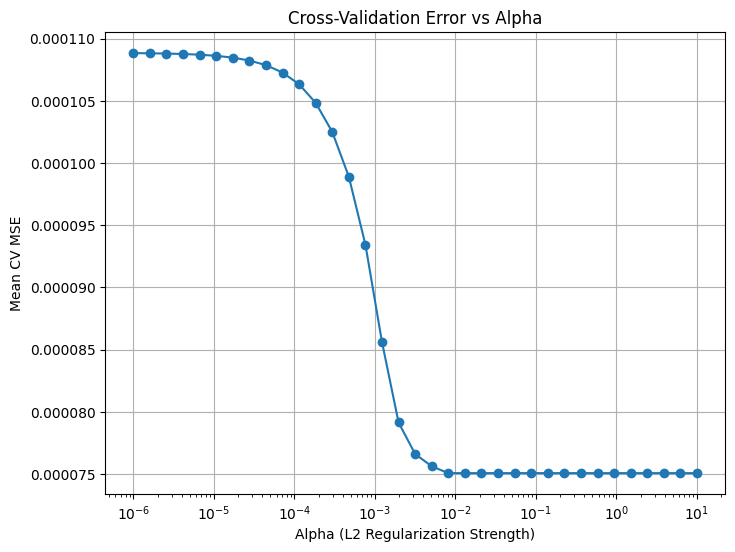

Best alpha (lambda): 0.008161400793251826
Best CV Mean RMSE: 0.00866417849983309
Final coefficients: [ 0. -0. -0.]
Index(['n_ensemble', 'n_epochs', 'trust_extra0'], dtype='object')
Final intercept: [0.80662705]
0.007220148749860894
cv_score    0.00722
dtype: float64


C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline

which='cv_score'
todo = np.logical_and(main, np.logical_not(np.isnan(p[which].to_numpy())))
#y = p[[which]][todo].to_numpy()-p[['cv_score']][todo].to_numpy()
y = p[[which]][todo]
X = p[['n_ensemble', 'n_epochs']]
#X = p[['extra_data', 'trust_neg', 'n_ensemble', 'use_best_epoch', 'n_epochs']][todo]
#X = p[['extra_data', 'use_best_epoch', 'n_ensemble']][todo]
#X['trust_neg1'] = (p['trust_neg']==1)[todo]
X['trust_extra0'] = (p['trust_extra']==0)[todo]
#X['trust_neg0'] = (p['trust_neg']==0)[todo]
#X['trust_neg4'] = (p['trust_neg']==4)[todo]
#X['yolov8m'] = (p['model_name']=='yolov8m')[todo]
#X = X[['extra_data', 'n_ensemble', 'yolov8m']]
#X = 0*X[['extra_data']]+1
#X = X[['use_best_epoch']]
#X['trust_neg2'] = X['trust_neg']**2
#X['yolov8m'] = (p['model_name']=='yolov8m')
#X['scale_std_clip_value2'] = X['scale_std_clip_value']**2
#X['lr0_times_nepochs2'] = X['lr0_times_nepochs']**2
#X = X[['extra_data']]

# Define candidate alphas (lambdas)
alphas = np.logspace(-6, 1, 35)

# Define pipeline explicitly with named steps
pipeline = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("ridge", sklearn.linear_model.Lasso())
])

# Define parameter grid (for Ridge alpha)
param_grid = {
    "ridge__alpha": alphas
}

# GridSearchCV with 5-fold cross-validation
grid_search = sklearn.model_selection.GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=len(y),
    scoring='neg_mean_squared_error',
    return_train_score=True
)

# Fit GridSearchCV
grid_search.fit(X, y)

# Extract results
results = grid_search.cv_results_
mean_test_scores = -results['mean_test_score']  # Convert to positive MSE
alphas_tested = results['param_ridge__alpha'].data.astype(float)

# Plot CV error as function of alpha
plt.figure(figsize=(8, 6))
plt.semilogx(alphas_tested, mean_test_scores, marker='o')
plt.xlabel("Alpha (L2 Regularization Strength)")
plt.ylabel("Mean CV MSE")
plt.title("Cross-Validation Error vs Alpha")
plt.grid(True)
plt.show()

# Report best alpha
best_alpha = grid_search.best_params_['ridge__alpha']
print("Best alpha (lambda):", best_alpha)
print("Best CV Mean RMSE:", np.sqrt(-grid_search.best_score_))

# Create a new pipeline with the best alpha
final_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("lasso", sklearn.linear_model.Lasso(alpha=best_alpha))
])

# Fit to full dataset
final_model.fit(X, y)

y_pred = final_model.predict(X)
p['residual'] = np.nan
#p.loc[todo,'residual'] = (y-y_pred).to_numpy()
p.loc[todo,'residual'] = (np.ravel(y)-y_pred)

# (Optional) Print final coefficients and intercept
lasso_model = final_model.named_steps['lasso']
print("Final coefficients:", lasso_model.coef_)
print(X.columns)
print("Final intercept:", lasso_model.intercept_)

print(np.std(p['residual'][todo]))
print(np.std(y))

In [13]:
# X_alt = copy.deepcopy(X)
# for c in X_alt.columns:
#     X_alt[c] = 0
# X_alt['lr0_times_nepochs'] = X['lr0_times_nepochs']
# X_alt['lr0_times_nepochs2'] = X['lr0_times_nepochs']**2
# y_pred_alt = final_model.predict(X_alt)
# plt.scatter(X_alt['lr0_times_nepochs'], y_pred_alt)

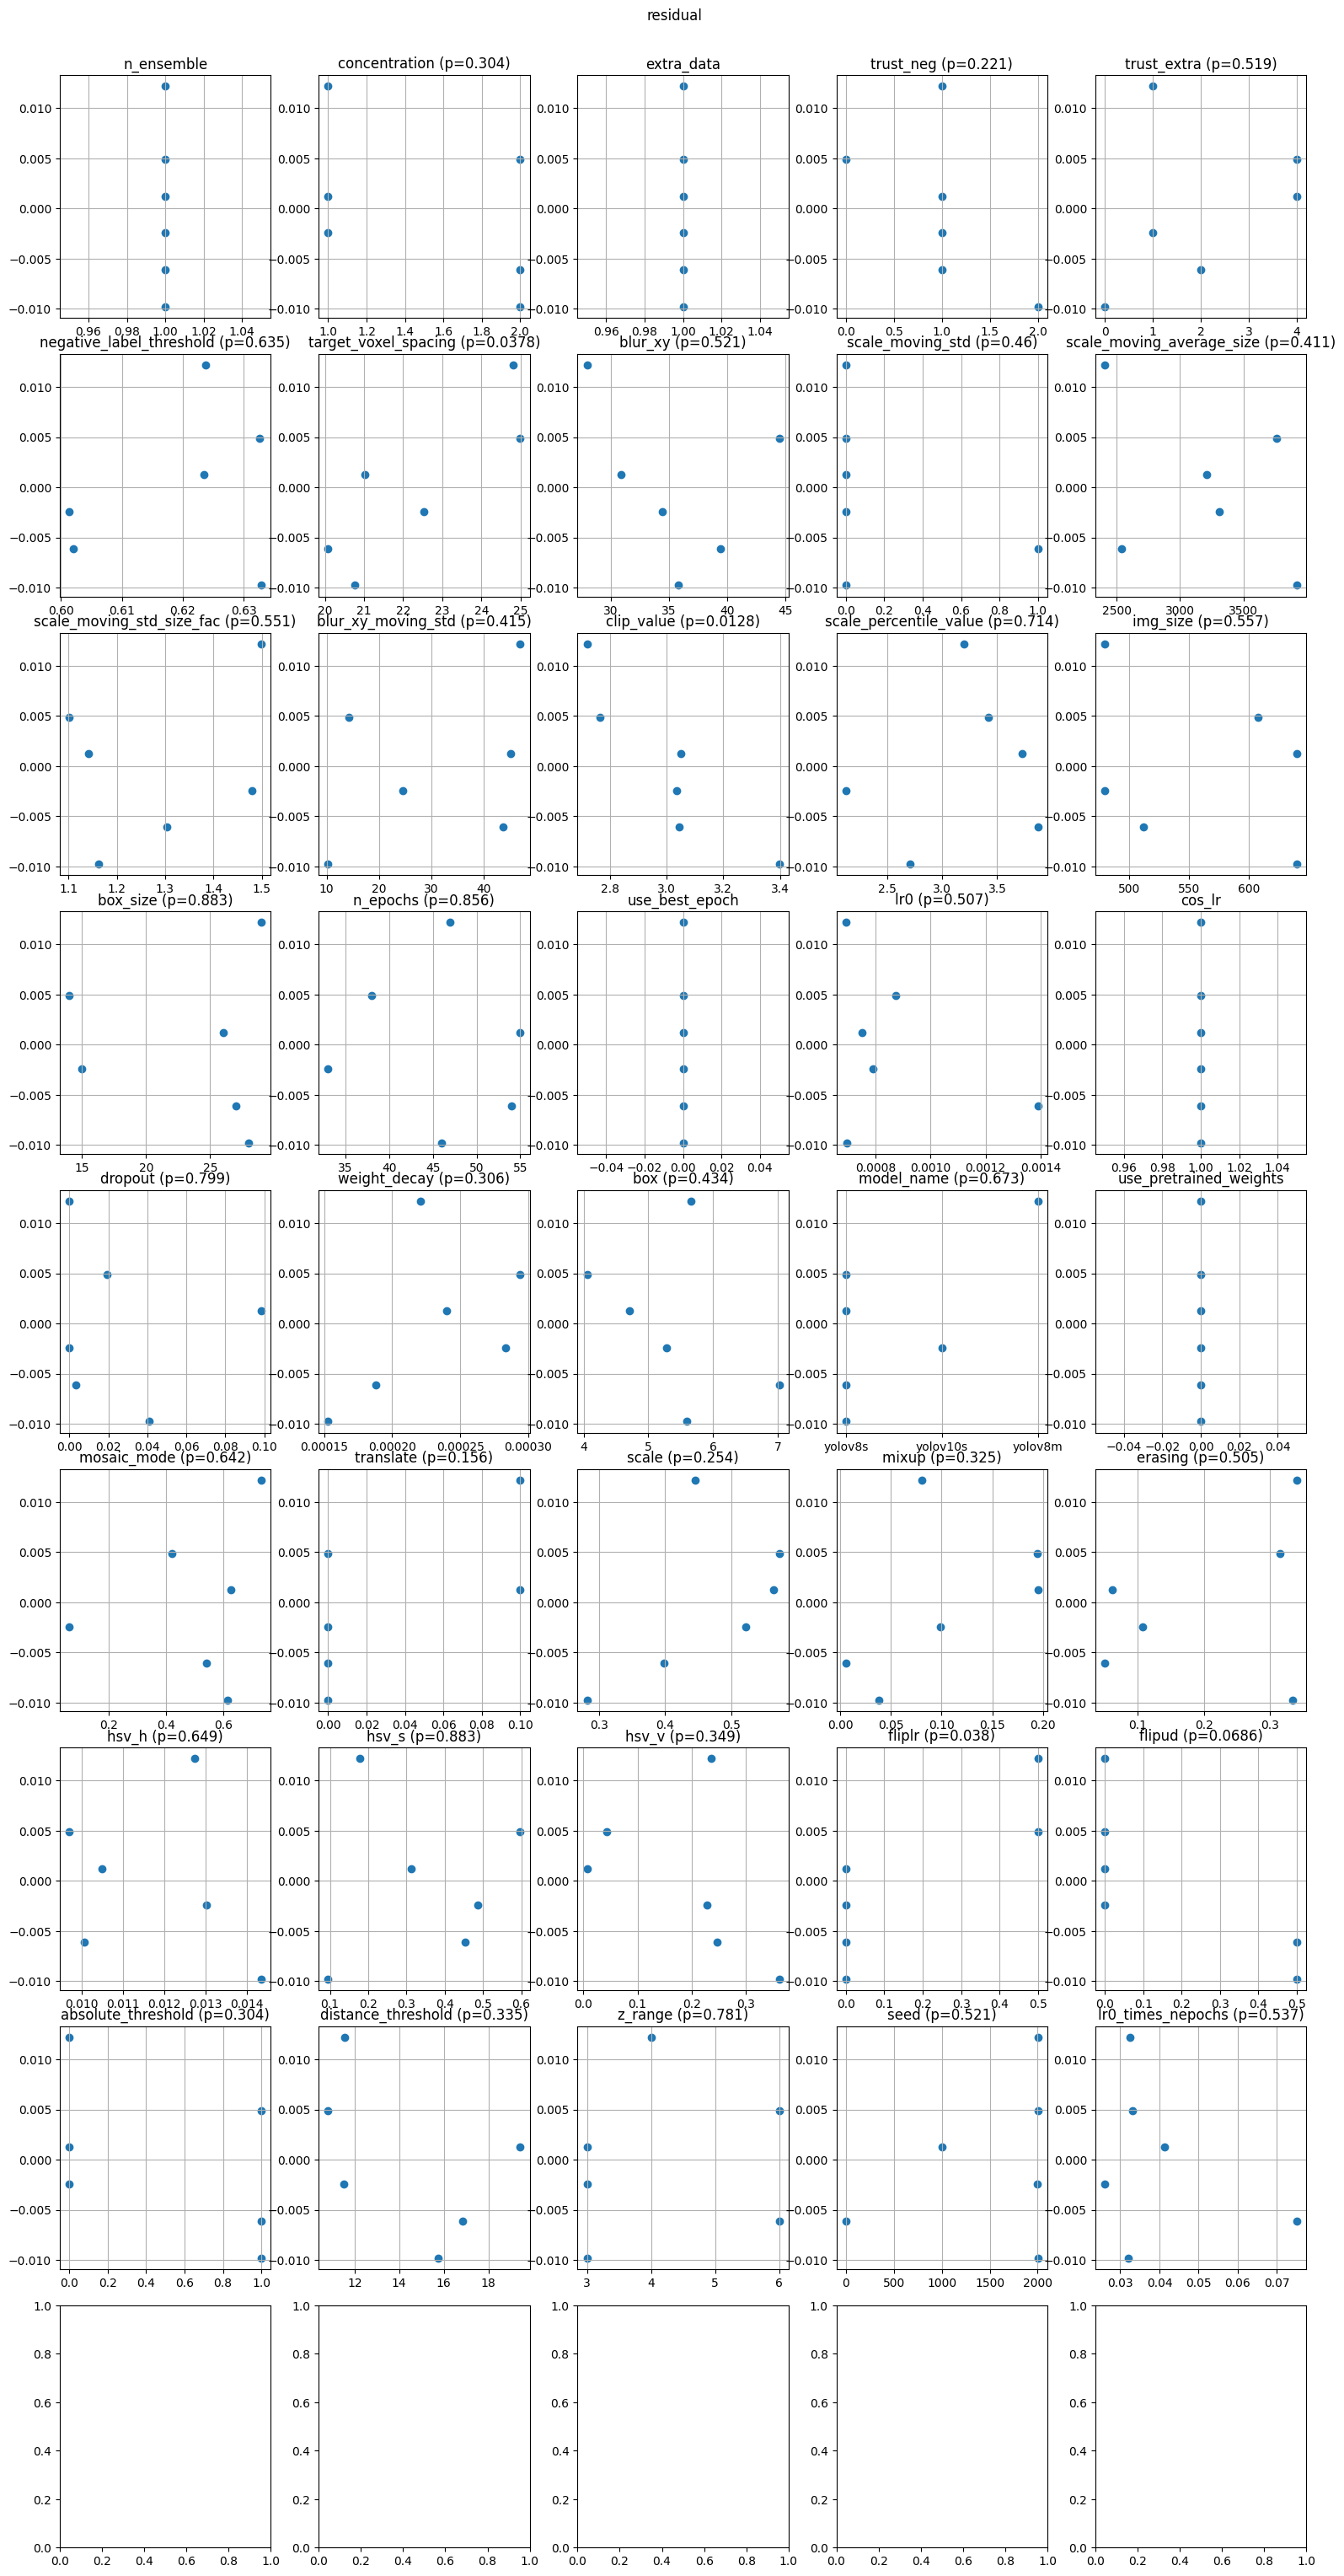

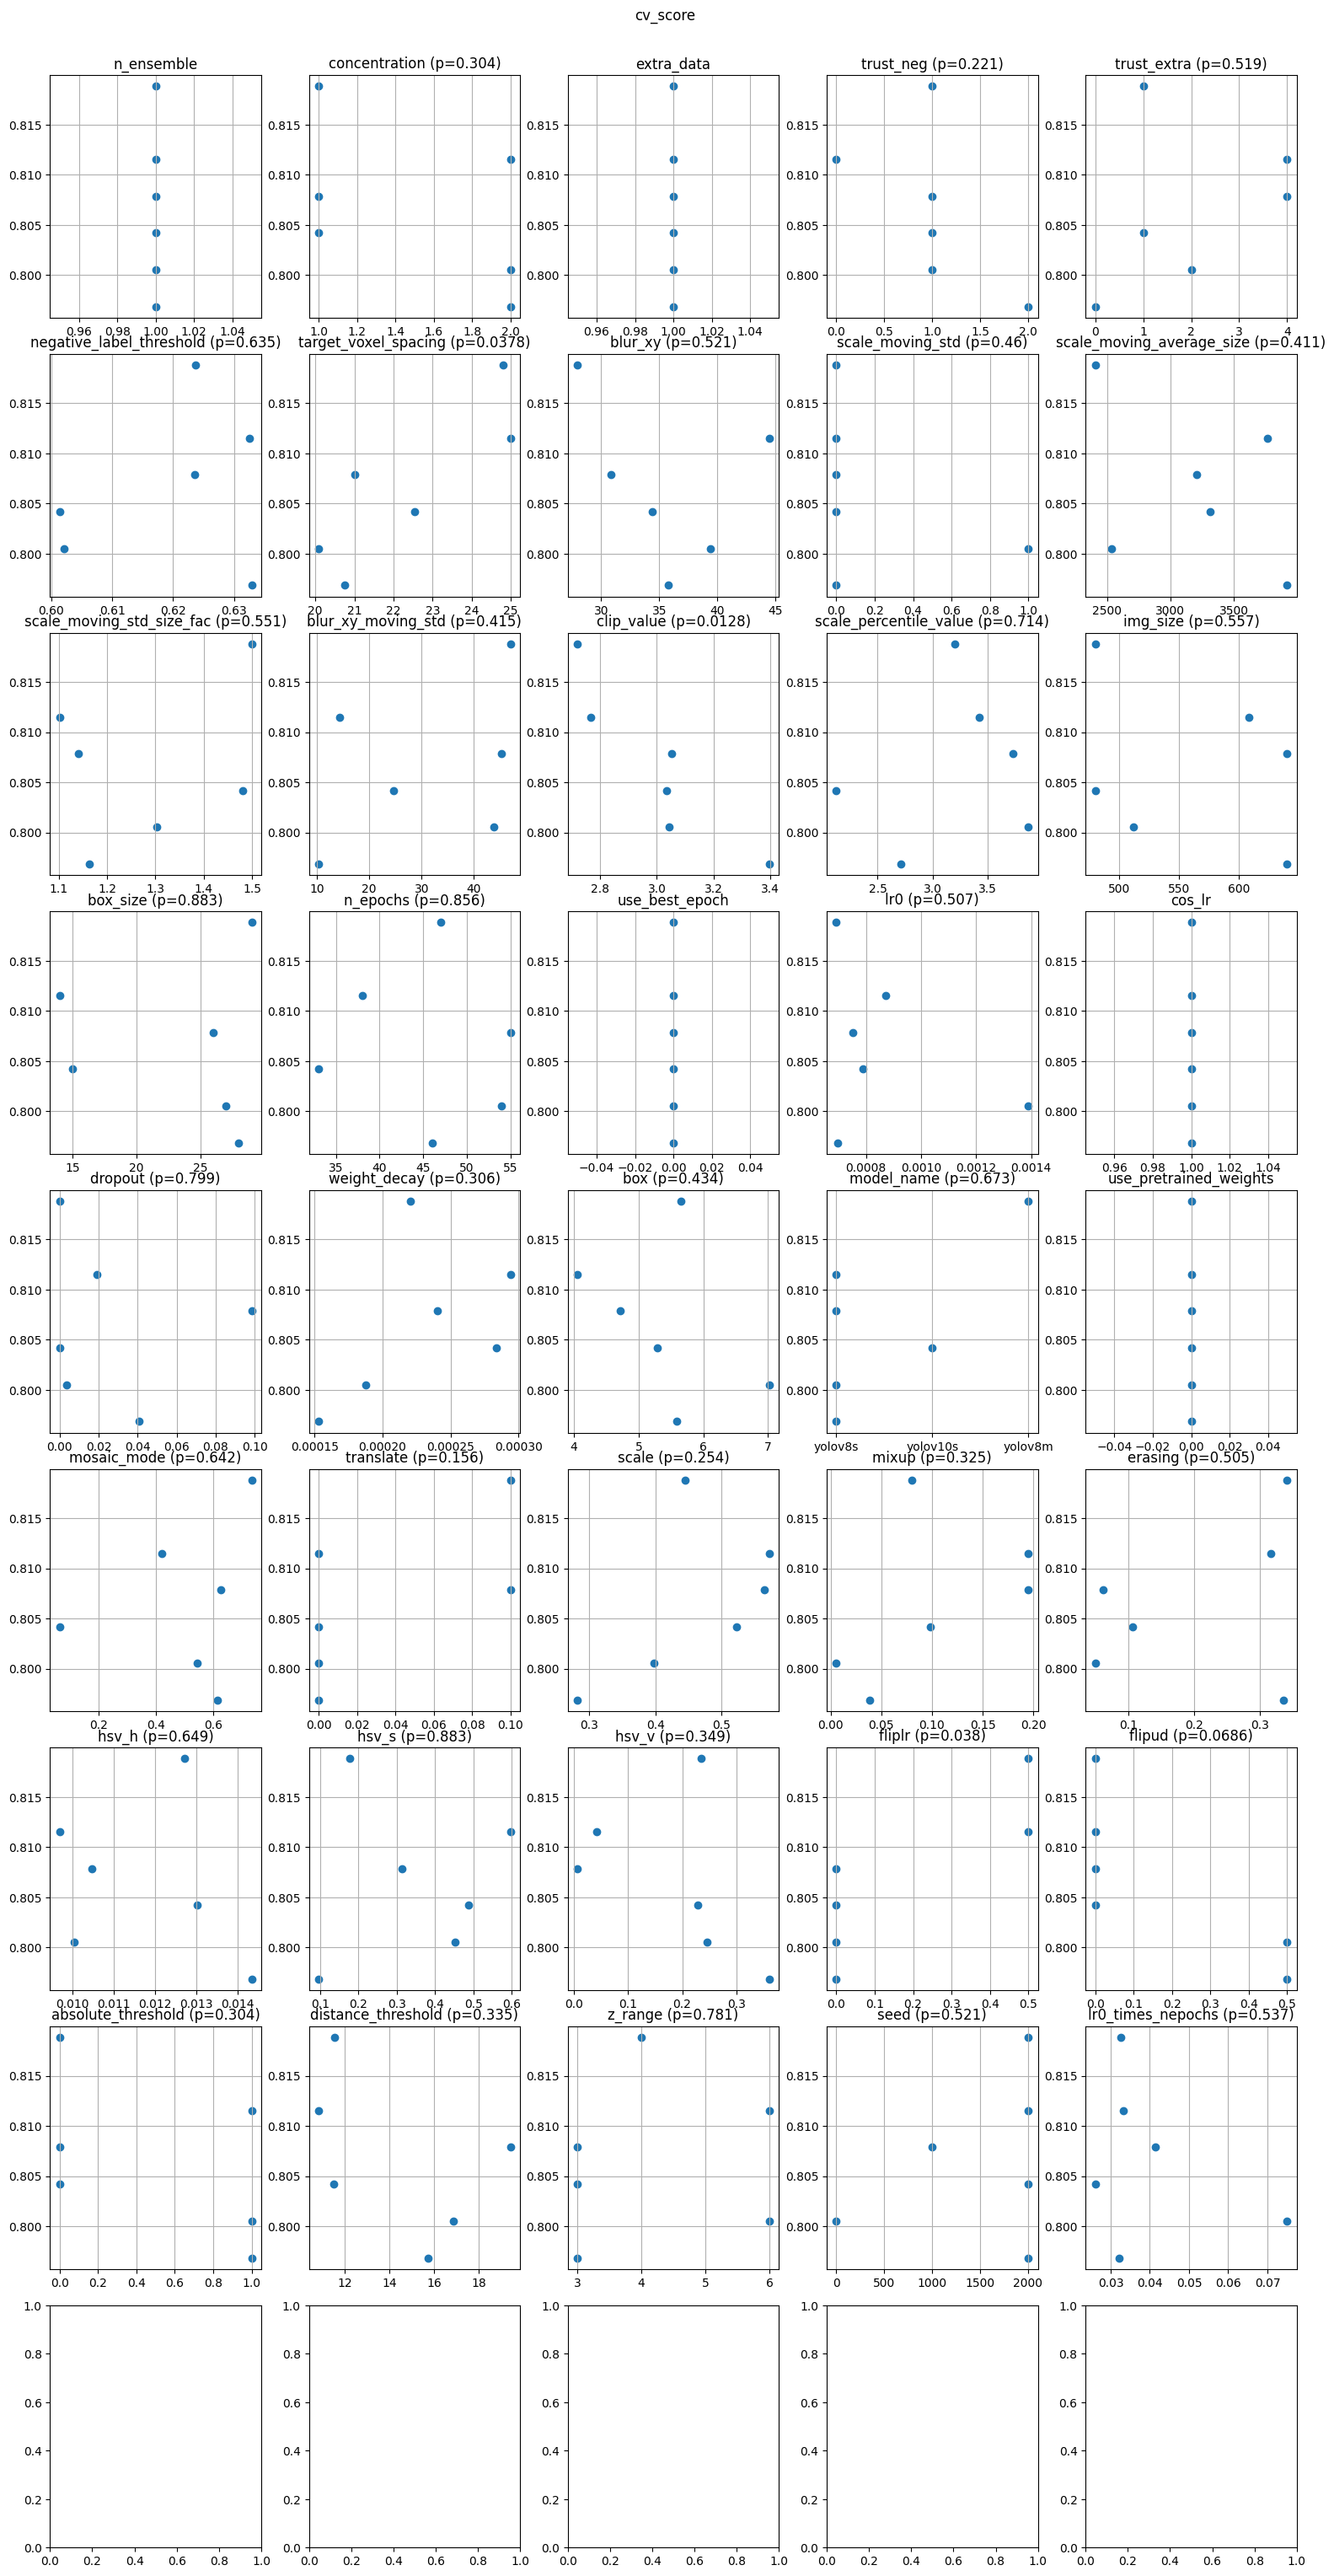

In [14]:
ncols = 5
nrows = len(to_plot)//ncols+1
figs = []
r = np.random.default_rng(seed=0)
#main = p['model_name']=='yolov8l'
for y_val in p.columns[[-1,-5]].to_list():
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18/ncols*nrows))
    plt.tight_layout(pad=10.0,h_pad=1,w_pad=1)
    figs.append(fig)
    plt.suptitle(y_val)
    for idx,d in enumerate(to_plot):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col]
        plt.sca(ax)        
        plt.xlabel('')
        plt.ylabel('')
        plt.grid(True)
        #p[y_val] = r.normal(size=p[y_val].shape)
        plt.scatter(p[d][main], p[y_val][main])
        #if y_val == 'k_score':
         #   plt.scatter(p[d][np.logical_not(main)], p[y_val][np.logical_not(main)])
       
        # fit
        if len(np.unique(p[d][main]))>1:
            pp = copy.deepcopy(p)
            if not pd.api.types.is_numeric_dtype(pp[d]) or pd.api.types.is_bool_dtype(pp[d]):
                pp[d] = pp[d].astype('category').cat.codes
            X = pp[[d]][main]
            X['intercept'] = 1.
            y = p[y_val][main]
            to_keep = np.logical_not(np.isnan(y))
            X = X[to_keep]; y=y[to_keep];
            model = sm.OLS(y,X)
            results=model.fit()
            p_val = results.pvalues[d]
            plt.title(f'{d} (p={p_val:.3})')
        else:
            plt.title(d)
        
        # if d == 'mask_sizes0':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][0] for m in model_list]
        # elif d == 'mask_sizes1':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][1] for m in model_list]
        # elif d == 'mask_sizes2':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][2] for m in model_list]
        # else:
        #     x_vals = [getattr(m, d)[model.particles_to_do[0]] for m in model_list]
        # if len(np.unique(x_vals))<8:
        #     #pass
        #     violin_plot(x_vals,score_vals)
        # else:
        #     plt.scatter(x_vals, score_vals)

In [15]:
# from pptx import Presentation
# from pptx.util import Inches

# prs = Presentation()
# blank = prs.slide_layouts[6]  # a blank slide layout

# for i, fig in enumerate(figs):
#     # save each figure to disk
#     img_path = f"figure_{i+1}.png"
#     fig.savefig(img_path, dpi=300, bbox_inches='tight')

#     # add a new slide, then add the image to it
#     slide = prs.slides.add_slide(blank)
#     slide.shapes.add_picture(
#         img_path,
#         Inches(1), Inches(1),          # left, top margins
#         width=Inches(8)                # scale width (height auto)
#     )

#     os.remove(img_path)

# prs.save("run_many_models_results.pptx")